In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 17 16:57:39 2020

@author: Aidans
"""
import numpy as np

class Richards_Equation():
    
    def __init__(self, num_nodes, dx, dt, max_dt, min_dt,
                 adaptive_dt_multiplier, adaptive_dt_reducer,
                 van_gen_alpha, van_gen_n, soil_resid_moisture, 
                 soil_porosity, K_saturated):
        
        """
        Parameters
        ----------
        num_nodes : number of nodes in the domain
        
        dx : node spacing (meters)
        
        dt : time step (seconds)
        
        max_dt : maximum timestep that can be taken (seconds)
        
        min_dt : minimum timestep that can be taken (s)
        
        adaptive_dt_multiplier : factor by which to increase dt if convergence is fast
            
        adaptive_dt_reducer : factor by which to decrease dt if convergence is slow
        
        report_times : how often times are reported
        
        soil_model : constituative relation (0 Brooks and Corey) (1 Van Genuchten)
        
        van_gen_alpha : van genuchen constituitve model parameter (float)
        
        van_gen_n : van genuchen constituitve model parameter (float)
        
        van_gen_m : van genuchen constituitve model parameter (float)
        
        soil_resid_moisture : residual soil moisture (m/m)
        
        soil_porosity : porosity of the soil (m/m)
        
        K_saturated : saturated hydraulic conductivity (m/s)
        
        Returns
        -------
        None."""
        
        ### Soil space domain
        self.num_nodes = num_nodes
        self.dx = dx
        self.soil_resid_moisture = soil_resid_moisture
        self.soil_porosity = soil_porosity
        self.K_saturated = K_saturated     
        
        ### time stepping
        self.dt = dt
        self.max_dt = max_dt
        self.min_dt = min_dt
        self.adaptive_dt_multiplier = adaptive_dt_multiplier
        self.adaptive_dt_reducer = adaptive_dt_reducer
        #self.report_times = np.linspace(0, self.time_end, 360)
        
        ###if model is soil moisture model is van genutchen
        self.van_gen_alpha = van_gen_alpha
        self.van_gen_n = van_gen_n
        self.van_gen_m = 1.0 - 1.0 / van_gen_n
        
        self.time = 0
        self.time_list = []
        self.head_list = []
        self.depths = np.linspace(self.num_nodes*dx, 0,  num_nodes)
        self.soil_moisture_list = []
               
        
    def solve_richards_eq(self, head_initial, BC_top_type, BC_top_val, BC_bot_type, BC_bot_val, time_end):
        """
        Runs the model for a given length of time
                
        Parameters
        ----------
        head_initial : the initial condition of the model
        
        BC_top_type : Flag whether the top boundary condition is Dirichlet (0) or Neumann (1)
        
        BC_top_value : Value of the boundary condition (m if Dirichlet) (m/s if Neumann)
        
        BC_bot_type : Flag whether the top boundary condition is Dirichlet (0) or Neumann (1)
        
        BC_bot_value : Value of the boundary condition (m if Dirichlet) (m/s if Neumann)

        time_end : Simulation length

        Returns
        -------
        Array of times, array of heads data at each time, 
        array of soil moisture data at each time, and the soil depth data"""
        
        forward_diff_rhs = self._forward_diff()
        backward_diff_rhs = self._backward_diff()        
        
        BC_top = np.zeros(head_initial.shape)
        BC_bot = np.zeros(head_initial.shape)
        # Store initial values   
        
        head_current = np.zeros(len(head_initial)+2)
        head_current[1:-1] = head_initial        
        
        ### Boundary Condition Stuff      
        if BC_top_type == 0:
            BC_top[0] = BC_top_val
            head_current[0] = BC_top_val            
            
        if BC_bot_type == 0:
            BC_bot[-1] = BC_bot_val
            head_current[-1] = BC_bot_val
        
        if BC_top_type == 1:
            backward_diff_rhs[0,0] = 0.0 #need to zero out
            BC_top[0] = BC_top_val          
            
        if BC_bot_type == 1:
            forward_diff_rhs[-1,-1] = 0.0
            BC_bot[0] = BC_bot_val
        
        self.time_list.append(self.time)     
        self.head_list.append(head_initial)
        
        soil_moisture = self._soil_moisture_van_genutchen(head_initial) 
        
        self.soil_moisture_list.append(soil_moisture)
        
        stop = 0        
        #Start time stepping        
        
        while self.time < time_end:
            iteration = 1
            #Start Picard Iteration
            while stop == 0:
                
                #Calculate the hydraulic conductivity
                K = self._hydraulic_conductivity_van_genutchen(head_current)
                #Calculate the current coinstitive head soil moisture relation
                dsoil_moisture = self._dsoil_moisture_van_genutchen(head_current[1:-1])
                #Calculate the current soil moisture
                soil_moisture_plus_1 = self._soil_moisture_van_genutchen(head_current[1:-1])
                
                #Calculate the interblock kydraulic conductivity
                K_inter_plus = np.diag(self._K_interblock(K[1:]))
                K_inter_minus = np.diag(self._K_interblock(K[:-1]))
                
                if BC_bot_type == 1:
                    K_inter_plus[-1, -1] = 0.0 #so we can set a flux
            
                if BC_top_type == 1:
                    K_inter_minus[0, 0] = 0.0
                    
                # construce lhs for A(delta-head) = b
                Kpgrad = - np.dot(K_inter_plus,self._forward_diff())
                Kmgrad = - np.dot(K_inter_minus,self._backward_diff())

                lhs =  1.0/self.dt*np.diag(dsoil_moisture) + 1.0/self.dx**2*(Kpgrad - Kmgrad)                

                #construct rhs

                dK = - (np.diag(K_inter_plus) - np.diag(K_inter_minus))/self.dx               
                
                if BC_bot_type == 1:
                    K_inter_plus[-1, -1] = 1.0 #so we can set a flux
            
                if BC_top_type == 1:
                    K_inter_minus[0, 0] = 1.0
                
                dH_plus = - np.dot(K_inter_plus,(np.dot(forward_diff_rhs,head_current[1:-1]) + BC_bot))
                dH_minus = - np.dot(K_inter_minus,(np.dot(backward_diff_rhs,head_current[1:-1]) - BC_top))                                   
                
                rhs = - 1.0/self.dx**2*(dH_plus - dH_minus) + dK - (soil_moisture_plus_1 - soil_moisture)/self.dt
                
                
                #solve the system of eqs
                delta_head = np.linalg.solve(lhs, rhs)

                #Set convergence tolerance
                if(np.linalg.norm(delta_head)<0.0000001):
                    stop = 1
                    self.time+=self.dt
                    print("Convergenice in ", iteration, " iterations with norm ", np.linalg.norm(delta_head))
                                  
                head_new = head_current[1:-1] + delta_head

                head_current[1:-1] = head_new
                
                #Adaptive solver options
                if (iteration<4 and stop ==1):
                    print( "Convergence is fast, increasing dt")
                    self.dt = np.min((self.dt*self.adaptive_dt_multiplier, self.max_dt))
                    print("New dt is ", self.dt)                    
                    
                if(iteration>150):
                    print("Convergence is slow, decreasing dt")
                    self.dt = np.max((self.dt*self.adaptive_dt_reducer, self.min_dt))
                    print("New dt is ", self.dt)
                    head_current[1:-1] = self.head_list[-1]#reset to last head
                    iteration = 0
                    
                iteration+=1
                
                if np.abs(self.dt - self.min_dt)< 1e-7:
                    print("Convergence not achieved with minimum allowed time step, ", self.min_dt)
                    raise RuntimeError("Convergence not achieved with minimum allowed time step")
            
            #update soil moisture for next time step
            print('The current time is', self.time, 's/', time_end, 's')              
            #Append the new states of interest
            #if np.isclose(self.time, self.report_times, 10.).any():
            self.time_list.append(self.time)
            head_right_now = head_current[1:-1] + 0.0
            self.head_list.append(head_right_now)

            
            soil_moisture_new = soil_moisture_plus_1
            soil_moisture = soil_moisture_new
            self.soil_moisture_list.append(soil_moisture_new)
            stop = 0
        
        return np.array(self.time_list), np.array(self.head_list), np.array(self.soil_moisture_list), self.depths
        
    def _forward_diff(self):
        """
        Returns the forward difference operator
        CAUTION: Boundary terms have not been delt with in this function
        
        Parameters
        ----------
        None.
        
        Returns
        -------
        Matrix form of forward difference"""
        
        matrix = - np.eye(self.num_nodes, k = 0) + np.eye(self.num_nodes, k = 1)
        return matrix

    def _backward_diff(self):
        """
        Returns the backwards difference operator
        CAUTION: Boundary terms have not been delt with in this function
        
        Parameters
        ----------
        None.
        
        Returns
        -------
        Matrix form of forward difference"""
        
        matrix = np.eye(self.num_nodes, k = 0) - np.eye(self.num_nodes, k = -1)
        return matrix            
       
        
    def _K_interblock(self, K):
        """
        Returns the soil moisture based given input head array using van genutchen model
                
        Parameters
        ----------
        K : hydraulic conductivity array (m/s)
        
        Returns
        -------
        K_interblock : intermediate hydraulic conductivites positive direction"""
        
        K_interblock = .5*(K[:-1] + K[1:])
        
        return K_interblock
        
    
    def _soil_moisture_van_genutchen(self, hydraulic_head):
        """
        Returns the soil moisture based given input head array using van genutchen model
                
        Parameters
        ----------
        head : hydraulic head (m) (array)
        
        soil_porosity : soil poroisty (m/m) (array)
        
        soil_resid_moisture : residual soil moisture (m/m) (array)
        
        head_air_entry : minimum pressure needed for water to be driven into soil
        
        Returns
        -------
        soil_m : the soil moisture (m/m)"""                    
        
        S = (1+(self.van_gen_alpha*np.abs(hydraulic_head))**self.van_gen_n)**self.van_gen_m
        
        soil_m = (self.soil_porosity - self.soil_resid_moisture)/S + self.soil_resid_moisture
            
        soil_m[(hydraulic_head>0)] = self.soil_porosity
            
        return soil_m
        
    def _dsoil_moisture_van_genutchen(self, head):
        """
        Returns the change in soil moisture with respect to a change in head brooks corey model
       
        Parameters
        ----------
        head : hydraulic head (m) (array)

        soil_porosity : soil poroisty (m/m) (array)

        soil_resid_moisture : residual soil moisture (m/m) (array)

        head_air_entry : minimum pressure needed for water to be driven into soil

        Returns
        -------
        dsoil_m : the change in soil moisture wrt to a change in head (1/m)"""

        S = (1+(self.van_gen_alpha*np.abs(head))**self.van_gen_n)**self.van_gen_m

        dSdh = self.van_gen_alpha*self.van_gen_m*self.van_gen_n*np.sign(head)*(1+(self.van_gen_alpha*np.abs(head))**self.van_gen_n)**(self.van_gen_m - 1)*(self.van_gen_alpha*np.abs(head))**(self.van_gen_n-1)

        dsoil_mdS = -(self.soil_porosity - self.soil_resid_moisture)/S**2

        dsoil_m = dsoil_mdS*dSdh
        
        dsoil_m[(head>0)] = 0.0
        
        return dsoil_m
        
        
    def _hydraulic_conductivity_van_genutchen(self, head):
        
        """
        Returns the hydraulic conductivity given some hydraulic potential van genutchen model
       
        Parameters
        ----------
        head : hydraulic head (m) (array)

        soil_porosity : soil poroisty (m/m) (array)

        soil_resid_moisture : residual soil moisture (m/m) (array)

        head_air_entry : minimum pressure needed for water to be driven into soil

        Returns
        -------
        K : the hydraulic conductivity (m/s)"""
        
        S = 1./(1. + (self.van_gen_alpha*np.abs(head))**self.van_gen_n)**self.van_gen_m
        
        S[(head>0)] = 1.0
        
        K = self.K_saturated*S**(1./2.)*(1. - (1. - S**(1./self.van_gen_m))**self.van_gen_m)**2.
        
        return K
       

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 19 16:55:45 2020

@author: aidan
"""
import nose
import numpy as np

class test_Richards_Equation(object):
    
    @classmethod
    def setup_class(cls):
        """This method is run once of each class before any tests are run """
        cls.num_nodes = 10
        cls.dx = .02
        cls.dt = 1.0
        cls.max_dt = 3.0
        cls.min_dt = .1
        cls.adaptive_dt_multiplier = 2.5
        cls.adaptive_dt_reducer = .25
        cls.van_gen_alpha = 2.2
        cls.van_gen_n = 2.2
        cls.van_gen_m = 1 - 1/cls.van_gen_n
        cls.soil_residual_moisture = .04
        cls.soil_porosity = .3
        cls.K_saturated = .0092 
        
    @classmethod
    def teardown_class(cls):
        """this method is run once for each class __after__ all tests are run"""
        pass
    
    def setUP(self):
        """this method is run once before __each__ test is run"""
        pass
    
    def teardown(self):
        """this method is run once after __each__ test is run"""
        pass
    
    def test_init(self):
        
        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
        
        nose.tools.assert_equal(soil.num_nodes, self.num_nodes)
        nose.tools.assert_equal(soil.dx, self.dx)
        nose.tools.assert_equal(soil.dt, self.dt)
        nose.tools.assert_equal(soil.max_dt, self.max_dt)
        nose.tools.assert_equal(soil.min_dt, self.min_dt)
        nose.tools.assert_equal(soil.adaptive_dt_multiplier, self.adaptive_dt_multiplier)
        nose.tools.assert_equal(soil.adaptive_dt_reducer, self.adaptive_dt_reducer)
        
    def test_forward_diff(self):

        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
        
        
        matrix = soil._forward_diff()
        
        test_matrix = np.zeros((self.num_nodes, self.num_nodes))
        
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == (j):
                    test_matrix[i, j] = -1
                if i == (j-1):
                    test_matrix[i, j] = 1
        print(test_matrix)
        print(matrix)
        Truth = (matrix == test_matrix).all()        
        nose.tools.assert_equal(Truth, True)
        
    def test_backward_diff(self):

        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
        
        
        matrix = soil._backward_diff()
        
        test_matrix = np.zeros((self.num_nodes, self.num_nodes))
        
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == (j+1):
                    test_matrix[i, j] = -1
                if i == (j):
                    test_matrix[i, j] = 1
        print(test_matrix)
        print(matrix)
        Truth = (matrix == test_matrix).all()        
        nose.tools.assert_equal(Truth, True)
        
        
    def test_soil_moisture_van_genutchen(self):
        
        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
                                     
        heads = np.array([-.5, -.2, 1.3, 1.67])
        
        soil_moisture = soil._soil_moisture_van_genutchen(heads)
                                     
        soil_moisture2 = (self.soil_porosity - self.soil_residual_moisture)/(1. + (self.van_gen_alpha*np.abs(heads))**self.van_gen_n)**self.van_gen_m + self.soil_residual_moisture
        
        soil_moisture2[2:] = self.soil_porosity
        
        for i in range(len(soil_moisture2)):
            
            nose.tools.assert_almost_equal(soil_moisture2[i], soil_moisture[i], 6)
        
    def test_dsoil_moisture_van_genutchen(self):
        
        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
                                     
        heads = np.array([-.5, -.2, 1.3, 1.67])
    
        soil_moisture = soil._dsoil_moisture_van_genutchen(heads)
        print(soil_moisture)        
        
        
        soil_moisture2 = -self.van_gen_alpha*self.van_gen_n*np.sign(heads)*(1./self.van_gen_n-1.)*(self.van_gen_alpha*np.abs(heads))**(self.van_gen_n-1.)*(self.soil_residual_moisture -self.soil_porosity)*((self.van_gen_alpha*np.abs(heads))**self.van_gen_n + 1)**(1./self.van_gen_n-2.)
        
        soil_moisture2[2:] = 0.0
        print(soil_moisture2)

        for i in range(len(soil_moisture2)):
            
            nose.tools.assert_almost_equal(soil_moisture2[i], soil_moisture[i], 6)
            
            
    def test_hydraulic_conductivity_van_genutchen(self):

        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)
                                     
        heads = np.array([-.5, -.2, 1.3, 1.67])
    
        K = soil._hydraulic_conductivity_van_genutchen(heads)
        
        S = 1./(1. + (self.van_gen_alpha*np.abs(heads))**self.van_gen_n)**self.van_gen_m        
        
        S[2:] = 1.0        
        
        K2 = self.K_saturated*S**(1./2.)*(1. - (1. - S**(1./self.van_gen_m))**self.van_gen_m)**2.

        for i in range(len(K2)):
            
            nose.tools.assert_almost_equal(K2[i], K[i], 6)
            
            
    def test_K_interblock(self):
        
        soil = Richards_Equation(self.num_nodes, self.dx, self.dt, self.max_dt, self.min_dt,
                 self.adaptive_dt_multiplier, self.adaptive_dt_reducer,
                 self.van_gen_alpha, self.van_gen_n, self.soil_residual_moisture, 
                 self.soil_porosity, self.K_saturated)

        heads = np.array([-.5, -.2, 1.3, 1.67])
    
        K = soil._hydraulic_conductivity_van_genutchen(heads)      
        
        K_interblock = soil._K_interblock(K)        
        
        for i in range(len(K_interblock)):
            
            Kintertest = (K[i]+K[i+1])/2            
            
            nose.tools.assert_almost_equal(K_interblock[i], Kintertest)
  

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 24 15:43:05 2020

@author: aidan
"""

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

## For couse soil
#0.0250 .3660 .04301 .52060
## For medium soil
#0.010 0.392 0.0249 1.1689 

num_nodes = 40
dx = .1
dt = 300.0
time_end = 3*3600
max_dt = 36
min_dt = 1.
adaptive_dt_multiplier = 2.0
adaptive_dt_reducer = .5
van_gen_alpha = .0249
van_gen_n =  1.1689
soil_resid_moisture = .010
soil_porosity = .392
K_saturated = 0.000000922

model = Richards_Equation(num_nodes, dx, dt, max_dt, min_dt,
                 adaptive_dt_multiplier, adaptive_dt_reducer,
                 van_gen_alpha, van_gen_n, soil_resid_moisture, 
                 soil_porosity, K_saturated)
                 

BC_top = 0
BC_bot = 0

BC_bot_val = -.6
BC_top_val = -.5 

head_init = np.ones(num_nodes)*BC_bot_val

#x = np.linspace(-10, 20, 100)
#plt.plot(x, model._soil_moisture_van_genutchen(x))
#plt.figure()
#plt.plot(x, model._dsoil_moisture_van_genutchen(x))


times, heads, moistures, depths = model.solve_richards_eq(head_init, BC_top, BC_top_val, BC_bot, BC_bot_val, time_end)

for i in range(3):
    for i in range(len(times)):
        clear_output(wait = True)
        plt.figure(figsize = (20,10))
        plt.subplot(121)
        plt.plot(heads[i], depths)
        plt.xlabel('Head (m)', fontsize = 18)
        plt.ylabel('Height above datum (m)', fontsize = 18)
        plt.xlim(-.61, -.49)
        plt.subplot(122)
        plt.plot(moistures[i], depths)
        plt.xlabel('Soil Moisture Content', fontsize = 18)
        plt.ylabel('Height above datum (m)', fontsize = 18)
        plt.show()
        print('Average Soil Moisture = ', np.mean(moistures[i]), ' Max Soil Moisture = .368')
        print('The Current time is ', times[i]/3600, 'hrs Out of 3 hrs')
    print('Would You Like To Watch Again?')
    keep_going = input()

<Figure size 2000x1000 with 2 Axes>

Average Soil Moisture =  0.39164404078592596  Max Soil Moisture = .368
The Current time is  3.0 hrs Out of 3 hrs
Would You Like To Watch Again?
1


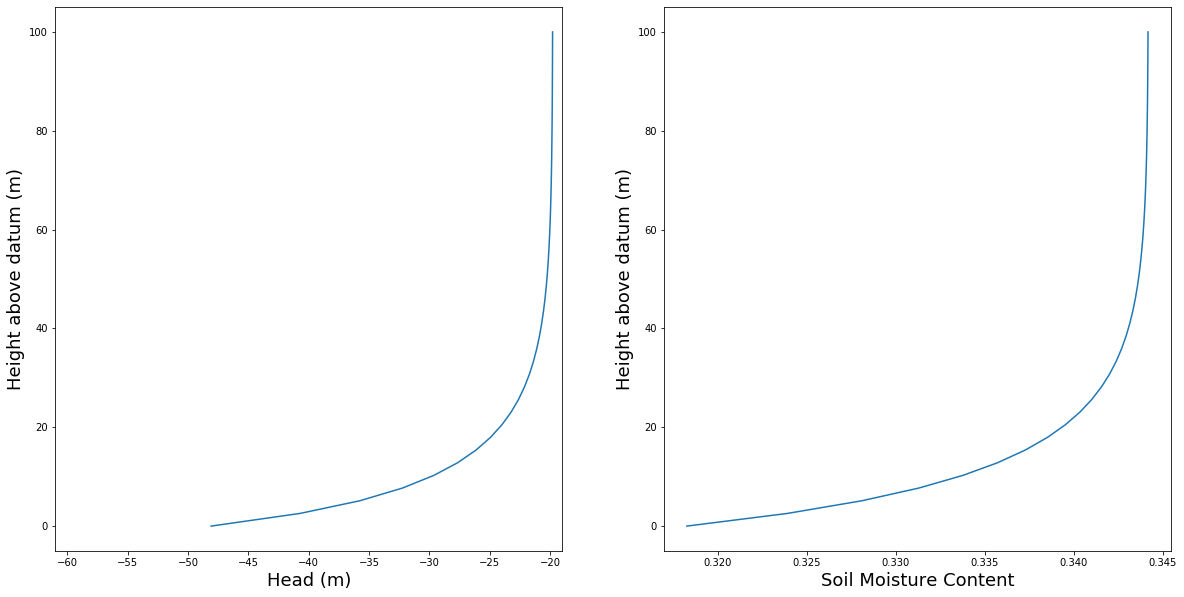

Average Soil Moisture =  0.34083771655992595  Max Soil Moisture = .368
The Current time is  6.0 hrs Out of 6 hrs
Would You Like To Watch Again?
1


In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 24 15:43:05 2020

@author: aidan
"""

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


num_nodes = 40
dx = 2.5
dt = 300.0
time_end = 6*3600
max_dt = 3600
min_dt = 1.
adaptive_dt_multiplier = 2.0
adaptive_dt_reducer = .5
van_gen_alpha = .0335
van_gen_n =  1.25
soil_resid_moisture = .102
soil_porosity = .368
K_saturated = 0.00922

model = Richards_Equation(num_nodes, dx, dt, max_dt, min_dt,
                 adaptive_dt_multiplier, adaptive_dt_reducer,
                 van_gen_alpha, van_gen_n, soil_resid_moisture, 
                 soil_porosity, K_saturated)
                 

BC_top = 1
BC_bot = 0

head_bot = -60.
head_top = 7.0e-4 

head_init = np.ones(num_nodes)*head_bot

#x = np.linspace(-10, 20, 100)
#plt.plot(x, model._soil_moisture_van_genutchen(x))
#plt.figure()
#plt.plot(x, model._dsoil_moisture_van_genutchen(x))

plt.figure()
times, heads, moistures, depths = model.solve_richards_eq(head_init, BC_top, head_top, BC_bot, head_bot, time_end)
print(head_init)

for i in range(3):
    for i in range(len(times)):
        clear_output(wait = True)
        plt.figure(figsize = (20,10))
        plt.subplot(121)
        plt.plot(heads[i], depths)
        plt.xlabel('Head (m)', fontsize = 18)
        plt.ylabel('Height above datum (m)', fontsize = 18)
        plt.xlim(-61, -19)
        plt.subplot(122)
        plt.plot(moistures[i], depths)
        plt.xlabel('Soil Moisture Content', fontsize = 18)
        plt.ylabel('Height above datum (m)', fontsize = 18)
        plt.show()
        print('Average Soil Moisture = ', np.mean(moistures[i]), ' Max Soil Moisture = .368')
        print('The Current time is ', times[i]/3600, 'hrs Out of 6 hrs')
    print('Would You Like To Watch Again?')
    keep_going = input()

https://bitbucket.org/aidanstansberry/aidan_richardsequation/src/master/